In [2]:
from scripts.imports import * 
from PIL import Image
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2, ToTensor
from torchsummary import summary
from torchmetrics import Accuracy, F1Score
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter('ignore')
# Prepare dataset
imgs, paths, labels =[], [], []
for root, dirs, files in sorted(os.walk("data")):
    #print(root, dirs, files)
    if (root == "data/no"):
        for file in files: 
            paths.append(root + "/" + file)
            imgs.append(cv.imread(root + "/" + file))
            labels.append(0)
    if (root == "data/yes"):
        for file in files:
            paths.append(root + "/" + file)
            imgs.append(cv.imread(root + "/" + file))
            labels.append(1)

df = pd.DataFrame()
df['paths']= paths
df['labels']=labels
df.sample()

,paths,labels
201,data/yes/Y249.JPG,1


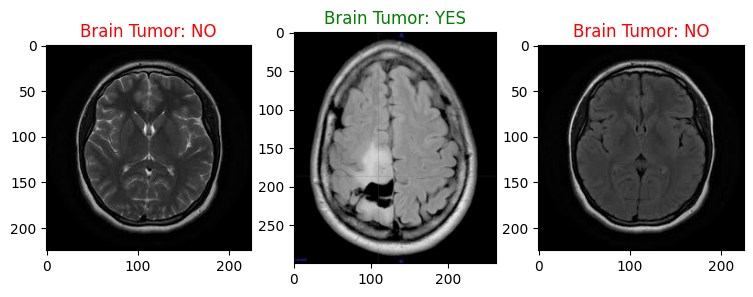

In [6]:
idxs = np.random.choice(len(imgs), size = 3)
fig, ax = plt.subplots(1 , 3, figsize = (9, 3))
for n, i in enumerate(idxs):
    ax[n].imshow(imgs[i])
    color = 'green' if labels[i] == 1 else 'red'
    ax[n].set_title(f"Brain Tumor: {'YES'if labels[i] == 1 else 'NO'}", color = color)

## Build Models

### CNN

In [7]:
class BrainDataset(torch.utils.data.Dataset):
    
    def __init__(self,df,preprocessing=None):
        self.image_paths = df['paths'].values.tolist()
        self.labels = df['labels'].values.tolist()
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        path = self.image_paths[i]
        image = cv.imread(path).astype('float32')
        label = self.labels[i]

        # apply preprocessing
        if self.preprocessing:
            image = self.preprocessing(image = image)['image']

        image = image.T
        return image, label
    
    def __len__(self):
        return len(self.image_paths)
    
def split_data(dataset, ratio = 0.9):

    total_size = len(dataset)
    train_size = int(ratio * total_size)
    val_size = total_size - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def human_readable(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{:.2f}{}'.format(num, ['', 'K', 'M', 'B', 'T'][magnitude])

def resize():
    comp = album.Compose([
        album.Resize(224, 224, p=1, always_apply=True)
    ])
    return comp

In [8]:
class ConvBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, ksp=(3, 2, 1), ks_pool= (2,2)):
        super().__init__()
        convolution = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        activation = nn.ReLU()
        pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #print(convolution, activation, pool)
        self.conv_block = nn.Sequential(convolution, activation, pool)

    def forward(self, x):
        return self.conv_block(x)

class CNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.convolutional_layers = nn.ModuleList()
        
        in_channels = 3
        for out_channels in config['convolutional_features']:
            #print(in_channels, out_channels)
            self.convolutional_layers.append(ConvBlock(in_channels=in_channels, out_channels=out_channels))
            in_channels = out_channels
        
        self.classifier = nn.ModuleList()
        
        classifier_features = [out_channels*(3*3)] + config["classifier_features"]
        for ddx in range(len(classifier_features)-1):
            self.classifier.append(nn.Sequential(*[nn.Linear(in_features=classifier_features[ddx], out_features=classifier_features[ddx+1]),
                                                   nn.LeakyReLU()]))
    def forward(self, x):
        for layer in self.convolutional_layers:
            x = layer(x)
        x = torch.flatten(x, 1)
        for layer in self.classifier:
            x = layer(x)
        return x
    
cnn_config = {"convolutional_features": [32, 64, 128],
              "adaptive_pool_size": 6,
              "classifier_features": [64, 16, 1]}

cnn_base = CNN(config=cnn_config)
print("basic cnn", human_readable(count_parameters(cnn_base)))

basic cnn 168.10K


In [9]:
def train(model, dataloader, loss_fn, metric_fn, optimizer, device):
    loss, metric_score = 0, 0
    
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        
        logits = model(X).squeeze()
        #print(X.shape, y.shape, logits.shape,
        #      type(X), type(logits))
        batch_loss = loss_fn(logits, y.float())
        metric_score += metric_fn(logits, y)
        
        loss += batch_loss
        
        batch_loss.backward()
        optimizer.step()
    
    loss /= len(dataloader)
    metric_score /= len(dataloader)
    print(f'Training -- Loss: {loss:.4f}, Metric: {metric_score*100:.2f}%')
    return loss, metric_score
    
def validate(model, dataloader, loss_fn, metric_fn, device):
    loss, metric_score = 0, 0
    
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            logits = model(X).squeeze()
            loss += loss_fn(logits, y.float())
            metric_score += metric_fn(logits, y)
        
        loss /= len(dataloader)
        metric_score /= len(dataloader)
        print(f'Validation -- Loss: {loss:.4f}, Metric: {metric_score*100:.2f}%')
    return loss, metric_score

def train_model(use_model, n_epochs = 10, lr=1e-4):

    model = use_model
    model_history = {"train": [], "validation": []}
    dataset = BrainDataset(df = df, preprocessing=resize())

    train_dataset, val_dataset = split_data(dataset=dataset, ratio=.85)

    train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size = 16, shuffle=True)
    
    #device = "mps" if getattr(torch, "has_mps", False) else "cuda" if torch.cuda.is_available() else "cpu"
    device = "cpu"
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    f1_fn = F1Score(task = 'binary').to(device)
    acc_fn = Accuracy(task = 'binary').to(device)
    metric_fn = acc_fn
    print("Metric is", "Accucracy" if metric_fn == acc_fn else "F1-score")
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(n_epochs):
        print(f'Epoch : # {epoch+1}')
        print('-'*30)
        train_metrics = train(model, train_dataloader, loss_fn, metric_fn, optimizer, device)
        val_metrics = validate(model, val_dataloader, loss_fn, metric_fn, device)
        model_history['train'].append(train_metrics)
        model_history['validation'].append(val_metrics)
    
    return model_history

In [12]:
cnn_config = {"convolutional_features": [32, 64, 128],
              "classifier_features": [64, 16, 1]}

cnn_base = CNN(config=cnn_config)
print("basic cnn", human_readable(count_parameters(cnn_base)))
cnn_performance = train_model(cnn_base, n_epochs=10, lr = 1e-4)

basic cnn 168.10K
Metric is Accucracy
Epoch : # 1
------------------------------
Training -- Loss: 0.6144, Metric: 66.71%
Validation -- Loss: 0.5078, Metric: 76.39%
Epoch : # 2
------------------------------
Training -- Loss: 0.5600, Metric: 73.72%
Validation -- Loss: 0.4617, Metric: 89.58%
Epoch : # 3
------------------------------
Training -- Loss: 0.5497, Metric: 78.32%
Validation -- Loss: 0.4923, Metric: 77.78%
Epoch : # 4
------------------------------
Training -- Loss: 0.5264, Metric: 77.42%
Validation -- Loss: 0.4572, Metric: 81.94%
Epoch : # 5
------------------------------
Training -- Loss: 0.5241, Metric: 78.06%
Validation -- Loss: 0.4958, Metric: 88.19%
Epoch : # 6
------------------------------
Training -- Loss: 0.5037, Metric: 79.21%
Validation -- Loss: 0.4911, Metric: 91.67%
Epoch : # 7
------------------------------
Training -- Loss: 0.5585, Metric: 75.51%
Validation -- Loss: 0.4430, Metric: 79.86%
Epoch : # 8
------------------------------
Training -- Loss: 0.4842, Metr

### ViT

In [13]:
class CreatePatches(nn.Module):
    def __init__(
        self, channels=3, embed_dim=768, patch_size=16
    ):
        super().__init__()
        self.patch = nn.Conv2d(
            in_channels=channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
    def forward(self, x):
        # Flatten along dim = 2 to maintain channel dimension.
        patches = self.patch(x).flatten(2).transpose(1, 2)
        return patches

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.pre_norm = nn.LayerNorm(embed_dim, eps=1e-06)
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm = nn.LayerNorm(embed_dim, eps=1e-06)
        self.MLP = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        x_norm = self.pre_norm(x)
        # MultiheadAttention returns attention output and weights,
        # we need only the outputs, so [0] index.
        attention_out, attention_weights = self.attention(x_norm, x_norm, x_norm, need_weights = True)
        x = x + attention_out
        x = x + self.MLP(self.norm(x))
        return x, attention_weights
    
class ViT(nn.Module):
    def __init__(
        self, 
        config
    ):
        """img_size=224,
        in_channels=3,
        patch_size=16,
        embed_dim=768,
        hidden_dim=3072,
        num_heads=12,
        num_layers=12,
        dropout=0.0,
        num_classes=1000"""
        img_size = config['img_size']
        in_channels = config['in_channels']
        patch_size = config['patch_size']
        embed_dim = config['embed_dim']
        hidden_dim = config['hidden_dim']
        num_heads = config['num_heads']
        num_layers = config['num_layers']
        dropout = config['dropout']
        num_classes = config['num_classes']

        if ("patches" in list(config.keys())):
            patches = config["patches"]
        else:
            patches = CreatePatches


        super().__init__()
        self.patch_size = patch_size
        num_patches = (img_size//patch_size) ** 2
        self.patches = patches(
            channels=in_channels,
            embed_dim=embed_dim,
            patch_size=patch_size
        )
        # Postional encoding.
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.attn_layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.attn_layers.append(
                AttentionBlock(embed_dim, hidden_dim, num_heads, dropout)
            )
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(embed_dim, eps=1e-06)
        self.head = nn.Linear(embed_dim, num_classes)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x, return_weights = False):
        x = self.patches(x)
        b, n, _ = x.shape
 
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)
        att_list = []
        for layer in self.attn_layers:
            x, att = layer(x)
            att_list.append(att)
        x = self.ln(x)
        x = x[:, 0]
        
        if (return_weights):
            return self.head(x), att_list
        return self.head(x)

In [14]:
config_vit = {
        "img_size": 224,
        "in_channels": 3,
        "patch_size":16,
        "embed_dim":48,
        "hidden_dim":128,
        "num_heads":6,
        "num_layers": 3,
        "dropout":0.0,
        "num_classes":1
}
vit_base = ViT(config=config_vit)
print("basic ViT", human_readable(count_parameters(vit_base)))
vit_performance = train_model(vit_base, n_epochs=10, lr=1e-3)

basic ViT 112.75K
Metric is Accucracy
Epoch : # 1
------------------------------
Training -- Loss: 0.6789, Metric: 40.69%
Validation -- Loss: 0.5906, Metric: 69.44%
Epoch : # 2
------------------------------
Training -- Loss: 0.6787, Metric: 60.65%
Validation -- Loss: 0.6169, Metric: 63.89%
Epoch : # 3
------------------------------
Training -- Loss: 0.6772, Metric: 40.69%
Validation -- Loss: 0.6432, Metric: 35.42%
Epoch : # 4
------------------------------
Training -- Loss: 0.6648, Metric: 47.83%
Validation -- Loss: 0.6006, Metric: 67.36%
Epoch : # 5
------------------------------
Training -- Loss: 0.6540, Metric: 61.35%
Validation -- Loss: 0.6042, Metric: 63.89%
Epoch : # 6
------------------------------
Training -- Loss: 0.6552, Metric: 64.92%
Validation -- Loss: 0.5661, Metric: 81.25%
Epoch : # 7
------------------------------
Training -- Loss: 0.6508, Metric: 65.37%
Validation -- Loss: 0.5896, Metric: 77.78%
Epoch : # 8
------------------------------
Training -- Loss: 0.6339, Metr

## Complexity Comparison

In [15]:
def generate_cnn_config(complexity = 1):


    num_layers = min(max(1,int(complexity)), 4)

    conv_features = [int(32*complexity), int(64*complexity), int(128*complexity)]
    class_features = [int(64*complexity)] + [int((64*complexity)/(4**n)) for n in range(1, num_layers)] + [1]
    config = {"convolutional_features": conv_features,
                "classifier_features": class_features}
    m = CNN(config=config)
    n_params = count_parameters(m)
    return config, n_params, human_readable(n_params)
complexities = [.125, .25, .5, 1, 2, 4, 10, 20]
cnn_configs = [generate_cnn_config(complexity=c) for c in complexities]
cnn_configs_params = [cnnc[1] for cnnc in cnn_configs]
cnn_configs_params_human = [cnnc[2] for cnnc in cnn_configs]

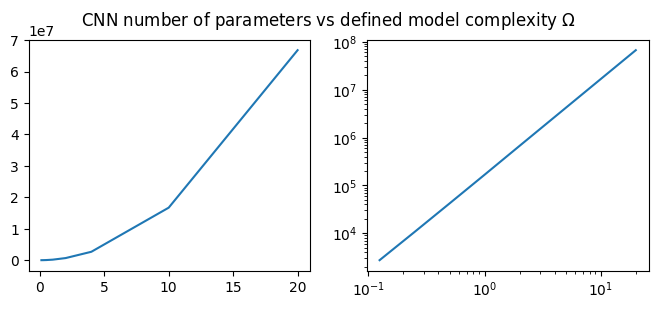

,0,1,2,3,4,5,6,7
complexity,0.125,0.25,0.5,1,2,4,10,20
parameters,2.75K,10.67K,42.08K,167.10K,670.02K,2.68M,16.71M,66.82M


In [16]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3))
ax[0].plot(complexities, cnn_configs_params)
ax[1].plot(complexities, cnn_configs_params)
ax[1].set_xscale("log")
ax[1].set_yscale("log")
fig.suptitle("CNN number of parameters vs defined model complexity $\Omega$")
plt.show()
pd.DataFrame([complexities, cnn_configs_params_human], index=["complexity", "parameters"])

In [32]:
pd.set_option("display.max_colwidth", 300)

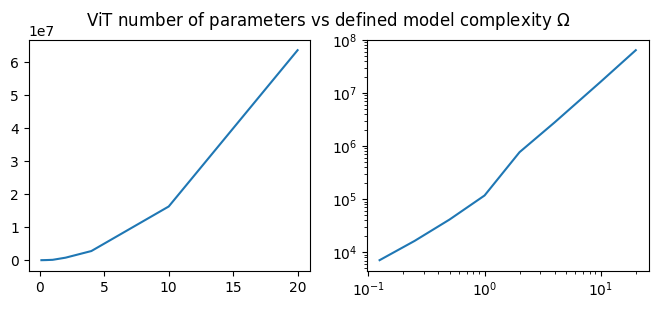

,0,1,2,3,4,5,6,7
complexity,0.125,0.25,0.5,1,2,4,10,20
parameters,7.12K,16.39K,41.42K,117.41K,766.95K,2.78M,16.28M,63.66M
configs,"{'img_size': 224, 'in_channels': 3, 'patch_size': 16, 'embed_dim': 6, 'hidden_dim': 18, 'num_heads': 6, 'num_layers': 3, 'dropout': 0.0, 'num_classes': 1}","{'img_size': 224, 'in_channels': 3, 'patch_size': 16, 'embed_dim': 12, 'hidden_dim': 36, 'num_heads': 6, 'num_layers': 3, 'dropout': 0.0, 'num_classes': 1}","{'img_size': 224, 'in_channels': 3, 'patch_size': 16, 'embed_dim': 24, 'hidden_dim': 72, 'num_heads': 6, 'num_layers': 3, 'dropout': 0.0, 'num_classes': 1}","{'img_size': 224, 'in_channels': 3, 'patch_size': 16, 'embed_dim': 48, 'hidden_dim': 144, 'num_heads': 6, 'num_layers': 3, 'dropout': 0.0, 'num_classes': 1}","{'img_size': 224, 'in_channels': 3, 'patch_size': 16, 'embed_dim': 144, 'hidden_dim': 432, 'num_heads': 6, 'num_layers': 3, 'dropout': 0.0, 'num_classes': 1}","{'img_size': 224, 'in_channels': 3, 'patch_size': 16, 'embed_dim': 288, 'hidden_dim': 864, 'num_heads': 6, 'num_layers': 3, 'dropout': 0.0, 'num_classes': 1}","{'img_size': 224, 'in_channels': 3, 'patch_size': 16, 'embed_dim': 720, 'hidden_dim': 2160, 'num_heads': 6, 'num_layers': 3, 'dropout': 0.0, 'num_classes': 1}","{'img_size': 224, 'in_channels': 3, 'patch_size': 16, 'embed_dim': 1440, 'hidden_dim': 4320, 'num_heads': 12, 'num_layers': 3, 'dropout': 0.0, 'num_classes': 1}"


In [33]:
def generate_vit_config(complexity = 1):

    #print(complexity)
    start_dim = 48
    if (complexity>1):
        start_dim=72


    embed_dim = int(start_dim*complexity)
    hidden_dim = 3*embed_dim
    num_heads= 6

    if (complexity > 10): 
        num_heads*=2
    num_layers = max(2+int(complexity), 6)

    config= {
        "img_size": 224,
        "in_channels": 3,
        "patch_size":16,
        "embed_dim":embed_dim,
        "hidden_dim":hidden_dim,
        "num_heads":num_heads,
        "num_layers":3,
        "dropout":0.0,
        "num_classes":1
    }
    m = ViT(config=config)
    n_params = count_parameters(m)
    return config, n_params, human_readable(n_params)

complexities = [.125, .25, .5, 1, 2, 4, 10, 20]
vit_configs = [generate_vit_config(complexity=c) for c in complexities]
vit_configs_figs = [vitc[0] for vitc in vit_configs]
vit_configs_params = [vitc[1] for vitc in vit_configs]
vit_configs_params_human = [vitc[2] for vitc in vit_configs]

fig, ax = plt.subplots(1, 2, figsize = (8, 3))
ax[0].plot(complexities, vit_configs_params)
ax[1].plot(complexities, vit_configs_params)
ax[1].set_xscale("log")
ax[1].set_yscale("log")
fig.suptitle("ViT number of parameters vs defined model complexity $\Omega$")
plt.show()
pd.DataFrame([complexities, vit_configs_params_human, vit_configs_figs], index=["complexity", "parameters", "configs"])

In [196]:
#training CNN models
cnn_models = [CNN(config=cfig[0]) for cfig in cnn_configs]

cnn_model_performances = []
for m in cnn_models:
    performance = train_model(use_model=m, n_epochs=20, lr=1e-3)
    cnn_model_performances.append(performance)


Metric is Accucracy
Epoch : # 1
------------------------------
Training -- Loss: 0.6729, Metric: 46.88%
Validation -- Loss: 0.6443, Metric: 61.81%
Epoch : # 2
------------------------------
Training -- Loss: 0.5876, Metric: 71.62%
Validation -- Loss: 0.5795, Metric: 63.19%
Epoch : # 3
------------------------------
Training -- Loss: 0.5672, Metric: 76.98%
Validation -- Loss: 0.5794, Metric: 73.61%
Epoch : # 4
------------------------------
Training -- Loss: 0.5498, Metric: 78.12%
Validation -- Loss: 0.6924, Metric: 54.86%
Epoch : # 5
------------------------------
Training -- Loss: 0.5248, Metric: 79.21%
Validation -- Loss: 0.6591, Metric: 64.58%
Epoch : # 6
------------------------------
Training -- Loss: 0.4941, Metric: 82.14%
Validation -- Loss: 0.5895, Metric: 65.97%
Epoch : # 7
------------------------------
Training -- Loss: 0.4547, Metric: 81.57%
Validation -- Loss: 0.5972, Metric: 64.58%
Epoch : # 8
------------------------------
Training -- Loss: 0.4339, Metric: 86.61%
Validat

In [198]:
vit_models = [ViT(config=cfig[0]) for cfig in vit_configs]
vit_model_performances = []
for m in vit_models:
    performance = train_model(use_model=m, n_epochs=20, lr=1e-3)
    vit_model_performances.append(performance)

Metric is Accucracy
Epoch : # 1
------------------------------
Training -- Loss: 0.6905, Metric: 40.69%
Validation -- Loss: 0.6825, Metric: 35.42%
Epoch : # 2
------------------------------
Training -- Loss: 0.6842, Metric: 40.11%
Validation -- Loss: 0.6709, Metric: 31.94%
Epoch : # 3
------------------------------
Training -- Loss: 0.6801, Metric: 40.11%
Validation -- Loss: 0.6604, Metric: 31.94%
Epoch : # 4
------------------------------
Training -- Loss: 0.6732, Metric: 38.97%
Validation -- Loss: 0.6632, Metric: 35.42%
Epoch : # 5
------------------------------
Training -- Loss: 0.6746, Metric: 40.11%
Validation -- Loss: 0.6693, Metric: 38.89%
Epoch : # 6
------------------------------
Training -- Loss: 0.6689, Metric: 38.97%
Validation -- Loss: 0.6554, Metric: 35.42%
Epoch : # 7
------------------------------
Training -- Loss: 0.6745, Metric: 41.26%
Validation -- Loss: 0.6505, Metric: 35.42%
Epoch : # 8
------------------------------
Training -- Loss: 0.6705, Metric: 40.69%
Validat

In [ ]:
cnn_perf_df = pd.DataFrame(cnn_model_performances)
cnn_perf_df['train_loss'] = cnn_perf_df['train'].apply(lambda p: [element[0].detach().numpy() for element in p])
cnn_perf_df['val_loss'] = cnn_perf_df['validation'].apply(lambda p: [element[0].detach().numpy() for element in p])
cnn_perf_df['train_acc'] = cnn_perf_df['train'].apply(lambda p: [element[1].detach().numpy() for element in p])
cnn_perf_df['val_acc'] = cnn_perf_df['validation'].apply(lambda p: [element[1].detach().numpy() for element in p])
#cnn_perf_df.sample()

[0.125, 0.25, 0.5, 1, 2, 4, 10, 20]


[(0.16342174, 0.0851396, 0.21088893),
 (0.33067031, 0.11701189, 0.30632563),
 (0.51728314, 0.1179558, 0.35453252),
 (0.70457834, 0.0882129, 0.34473046),
 (0.86641628, 0.17387796, 0.27070818),
 (0.94291042, 0.37549479, 0.26369821),
 (0.96173392, 0.57988594, 0.41844491),
 (0.96656022, 0.75658231, 0.62527295)]

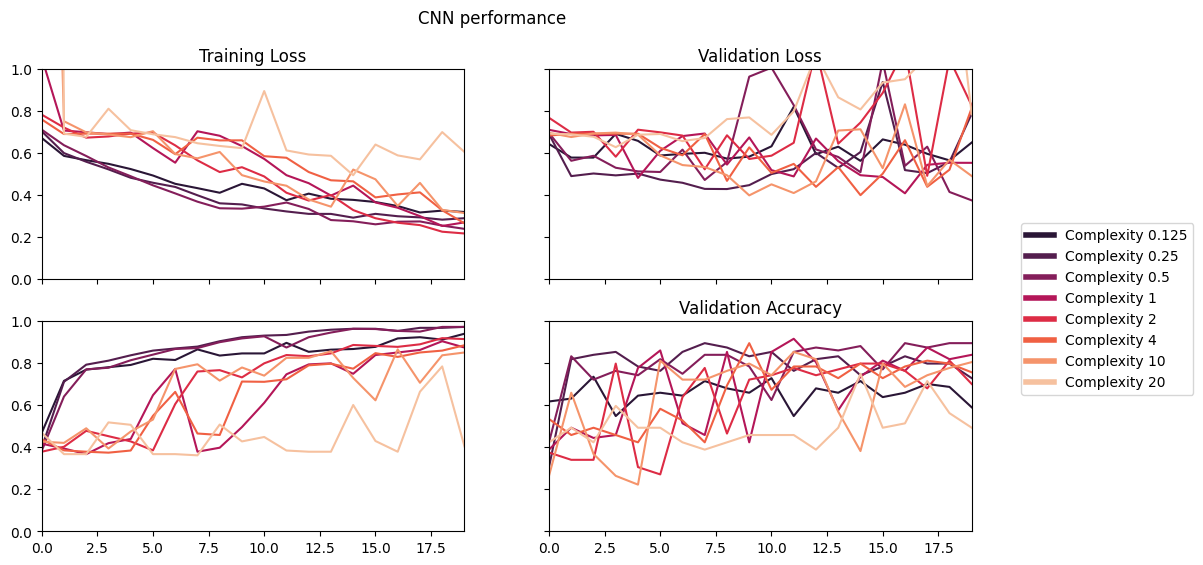

In [242]:
palette = sns.color_palette("rocket", 8)
print(complexities)
display(palette)
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (12, 6))

ax[0, 0].set_xlim(0,19)
ax[0, 0].set_ylim(0,1)
for cdx, curve in enumerate(cnn_perf_df['train_loss'].values.tolist()):
    ax[0,0].plot(curve, c= palette[cdx])
ax[0,0].set_title("Training Loss")
for cdx, curve in enumerate(cnn_perf_df['val_loss'].values.tolist()):
    ax[0,1].plot(curve, c= palette[cdx])
ax[0,1].set_title("Validation Loss")
for cdx, curve in enumerate(cnn_perf_df['train_acc'].values.tolist()):
    ax[1,0].plot(curve, c= palette[cdx])
ax[1,1].set_title("Training Loss")
for cdx, curve in enumerate(cnn_perf_df['val_acc'].values.tolist()):
    ax[1,1].plot(curve, c= palette[cdx], label = f"Complexity {complexities[cdx]}")
ax[1,1].set_title("Validation Accuracy")

leg = ax[1,1].legend(bbox_to_anchor = (1.1, 1.5))
for line in leg.get_lines():
    line.set_linewidth(4.0)
fig.suptitle("CNN performance")
plt.show()

In [237]:
vit_perf_df = pd.DataFrame(vit_model_performances)
vit_perf_df['train_loss'] = vit_perf_df['train'].apply(lambda p: [element[0].detach().numpy() for element in p])
vit_perf_df['val_loss'] = vit_perf_df['validation'].apply(lambda p: [element[0].detach().numpy() for element in p])
vit_perf_df['train_acc'] = vit_perf_df['train'].apply(lambda p: [element[1].detach().numpy() for element in p])
vit_perf_df['val_acc'] = vit_perf_df['validation'].apply(lambda p: [element[1].detach().numpy() for element in p])
vit_perf_df.sample()

,train,validation,train_loss,val_loss,train_acc,val_acc
0,"[(tensor(0.6905, grad_fn=<DivBackward0>), tens...","[(tensor(0.6825), tensor(0.3542)), (tensor(0.6...","[0.69050807, 0.6842054, 0.68014145, 0.67320716...","[0.6824929, 0.6708775, 0.6604295, 0.6631839, 0...","[0.40688777, 0.40114793, 0.40114793, 0.3896683...","[0.35416666, 0.31944445, 0.31944445, 0.3541666..."


[0.125, 0.25, 0.5, 1, 2, 4, 10, 20]


[(0.16342174, 0.0851396, 0.21088893),
 (0.33067031, 0.11701189, 0.30632563),
 (0.51728314, 0.1179558, 0.35453252),
 (0.70457834, 0.0882129, 0.34473046),
 (0.86641628, 0.17387796, 0.27070818),
 (0.94291042, 0.37549479, 0.26369821),
 (0.96173392, 0.57988594, 0.41844491),
 (0.96656022, 0.75658231, 0.62527295)]

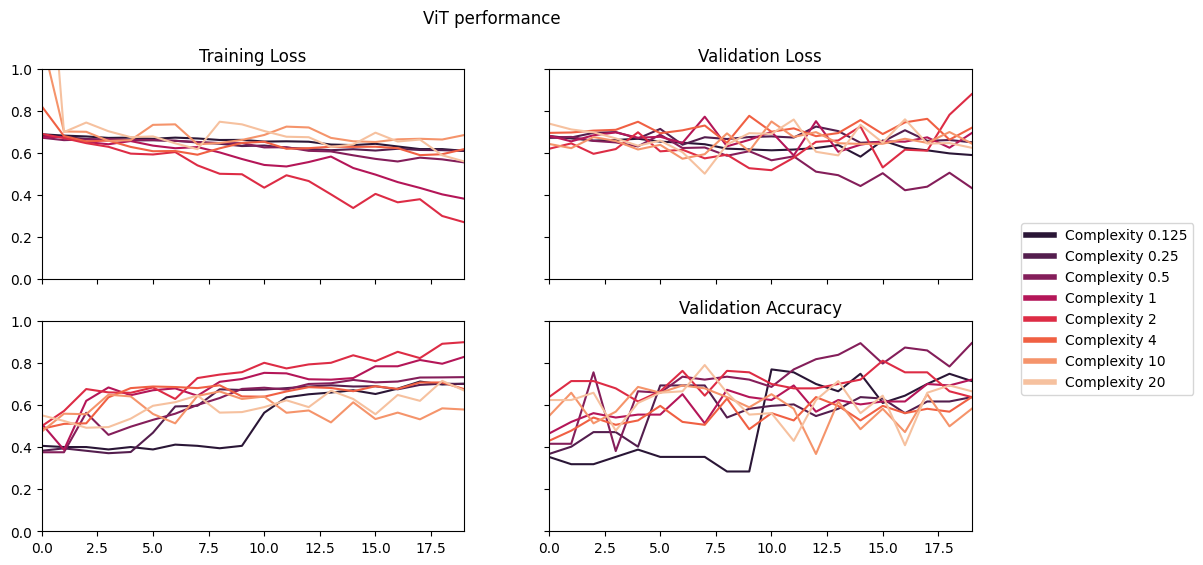

In [243]:
palette = sns.color_palette("rocket", 8)
print(complexities)
display(palette)
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (12, 6))

ax[0, 0].set_xlim(0,19)
ax[0, 0].set_ylim(0,1)
for cdx, curve in enumerate(vit_perf_df['train_loss'].values.tolist()):
    ax[0,0].plot(curve, c= palette[cdx])
ax[0,0].set_title("Training Loss")
for cdx, curve in enumerate(vit_perf_df['val_loss'].values.tolist()):
    ax[0,1].plot(curve, c= palette[cdx])
ax[0,1].set_title("Validation Loss")
for cdx, curve in enumerate(vit_perf_df['train_acc'].values.tolist()):
    ax[1,0].plot(curve, c= palette[cdx])
ax[1,1].set_title("Training Loss")
for cdx, curve in enumerate(vit_perf_df['val_acc'].values.tolist()):
    ax[1,1].plot(curve, c= palette[cdx], label = f"Complexity {complexities[cdx]}")
ax[1,1].set_title("Validation Accuracy")

leg = ax[1,1].legend(bbox_to_anchor = (1.1, 1.5))
for line in leg.get_lines():
    line.set_linewidth(4.0)
#ax[1, 1].legend(bbox_to_anchor = (1.1, 1.5))

fig.suptitle("ViT performance")
plt.show()

In [270]:
# comparison

cnn_perf_df['complexities'] = complexities
#last epoch
cnn_perf_df['le_train_loss'] = cnn_perf_df['train_loss'].apply(lambda p: np.mean(p[-3:-1]))
cnn_perf_df['le_val_loss'] = cnn_perf_df['val_loss'].apply(lambda p: np.mean(p[-3:-1]))
cnn_perf_df['le_train_acc'] = cnn_perf_df['train_acc'].apply(lambda p: np.mean(p[-3:-1]))
cnn_perf_df['le_val_acc'] = cnn_perf_df['val_acc'].apply(lambda p: np.mean(p[-3:-1]))

vit_perf_df['complexities'] = complexities
vit_perf_df['le_train_loss'] = vit_perf_df['train_loss'].apply(lambda p: np.mean(p[-3:-1]))
vit_perf_df['le_val_loss'] = vit_perf_df['val_loss'].apply(lambda p: np.mean(p[-3:-1]))
vit_perf_df['le_train_acc'] = vit_perf_df['train_acc'].apply(lambda p: np.mean(p[-3:-1]))
vit_perf_df['le_val_acc'] = vit_perf_df['val_acc'].apply(lambda p: np.mean(p[-3:-1]))


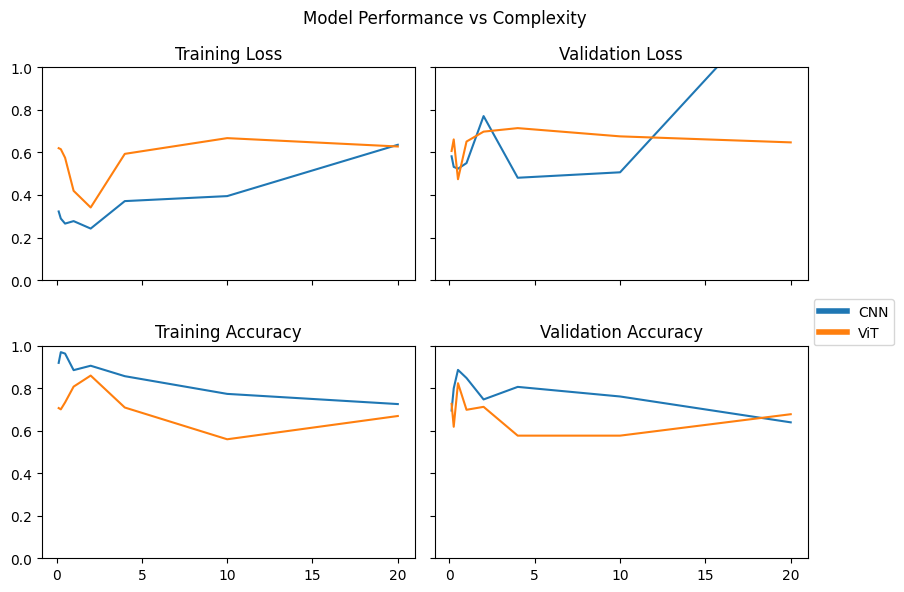

In [274]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (9, 6))


#ax[0, 0].set_xlim(0,19)
ax[0, 0].set_ylim(0,1)
ax[0,0].plot(cnn_perf_df['complexities'], cnn_perf_df['le_train_loss'])
ax[0,0].plot(vit_perf_df['complexities'], vit_perf_df['le_train_loss'])
ax[0,0].set_title("Training Loss")

ax[0,1].plot(cnn_perf_df['complexities'], cnn_perf_df['le_val_loss'])
ax[0,1].plot(vit_perf_df['complexities'], vit_perf_df['le_val_loss'])
ax[0,1].set_title("Validation Loss")

ax[1,0].plot(cnn_perf_df['complexities'], cnn_perf_df['le_train_acc'])
ax[1,0].plot(vit_perf_df['complexities'], vit_perf_df['le_train_acc'])
ax[1,0].set_title("Training Accuracy")

ax[1,1].plot(cnn_perf_df['complexities'], cnn_perf_df['le_val_acc'],label= "CNN")
ax[1,1].plot(vit_perf_df['complexities'], vit_perf_df['le_val_acc'],label= "ViT")
ax[1,1].set_title("Validation Accuracy")


leg = ax[1,1].legend(bbox_to_anchor = (1.25, 1.25))
for line in leg.get_lines():
    line.set_linewidth(4.0)

fig.suptitle("Model Performance vs Complexity")
plt.tight_layout()
plt.show()

## Attention 

We would also like to visualize these attention weights

In [441]:
good_vit_config = generate_vit_config(complexity=2)[0]
print(good_vit_config)
good_vit = ViT(config=good_vit_config)
performance = train_model(use_model=good_vit, n_epochs=50, lr=1e-3)

{'img_size': 224, 'in_channels': 3, 'patch_size': 16, 'embed_dim': 144, 'hidden_dim': 432, 'num_heads': 6, 'num_layers': 3, 'dropout': 0.0, 'num_classes': 1}
Metric is Accucracy
Epoch : # 1
------------------------------
Training -- Loss: 0.7034, Metric: 59.44%
Validation -- Loss: 0.5935, Metric: 63.89%
Epoch : # 2
------------------------------
Training -- Loss: 0.6798, Metric: 60.33%
Validation -- Loss: 0.5691, Metric: 75.00%
Epoch : # 3
------------------------------
Training -- Loss: 0.6854, Metric: 50.13%
Validation -- Loss: 0.6288, Metric: 71.53%
Epoch : # 4
------------------------------
Training -- Loss: 0.6738, Metric: 60.46%
Validation -- Loss: 0.5708, Metric: 71.53%
Epoch : # 5
------------------------------
Training -- Loss: 0.6395, Metric: 65.82%
Validation -- Loss: 0.5430, Metric: 75.69%
Epoch : # 6
------------------------------
Training -- Loss: 0.6237, Metric: 66.26%
Validation -- Loss: 0.5225, Metric: 81.25%
Epoch : # 7
------------------------------
Training -- Loss:

In [34]:
good_vit.eval()


def get_attention_map(img, layer=2):
    img = resize()(image=img)['image'][:,:,:,None]
    img = torch.permute(torch.tensor(img, dtype=torch.float32), (3, 2, 1, 0))
    pred, att = good_vit(img, return_weights = True)
    last = att[layer]
    cls = torch.mean(last[:, 1:, 1:], dim=1)
    num_patches = cls.size(-1)
    size = int(np.sqrt(num_patches))
    cls = cls.view(-1, size, size)
    attention_maps = cls.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(224, 224), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    return attention_maps.squeeze().detach().numpy()

NameError: name 'good_vit' is not defined

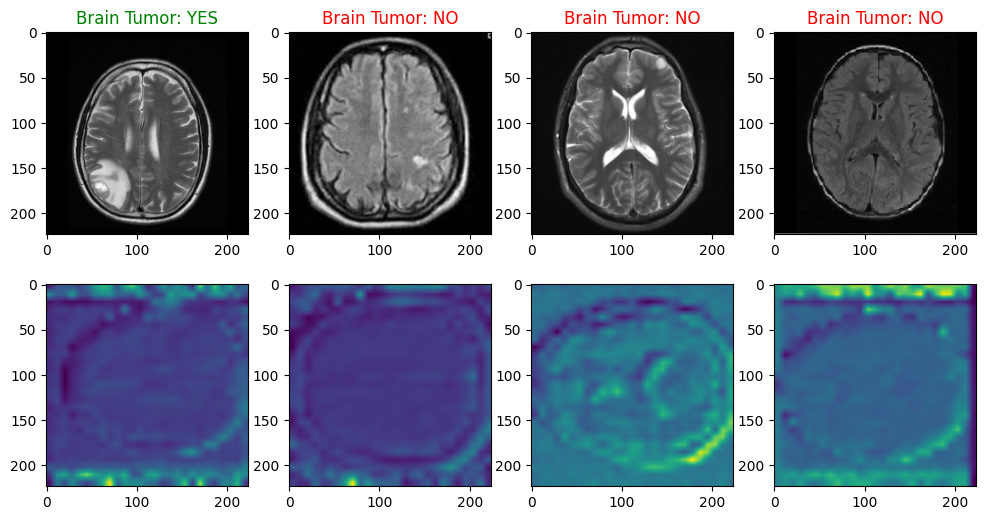

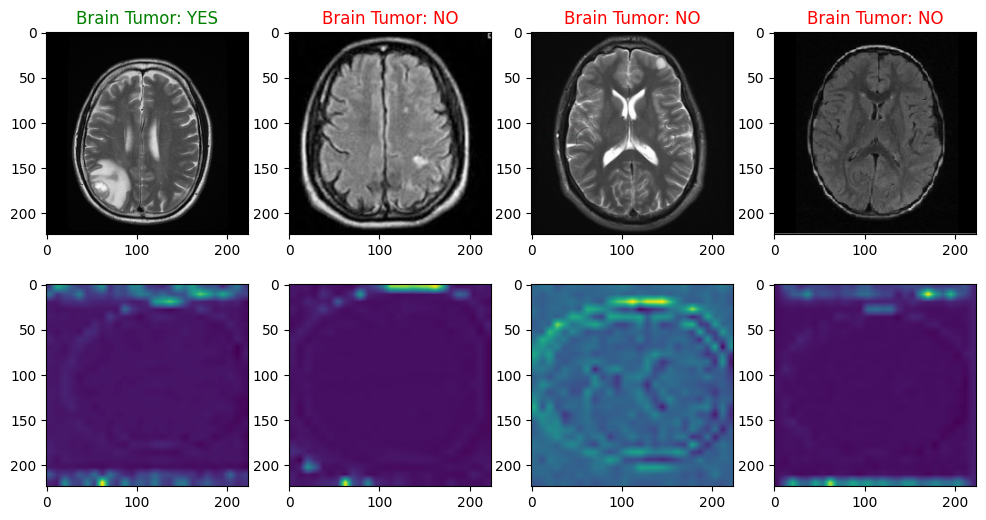

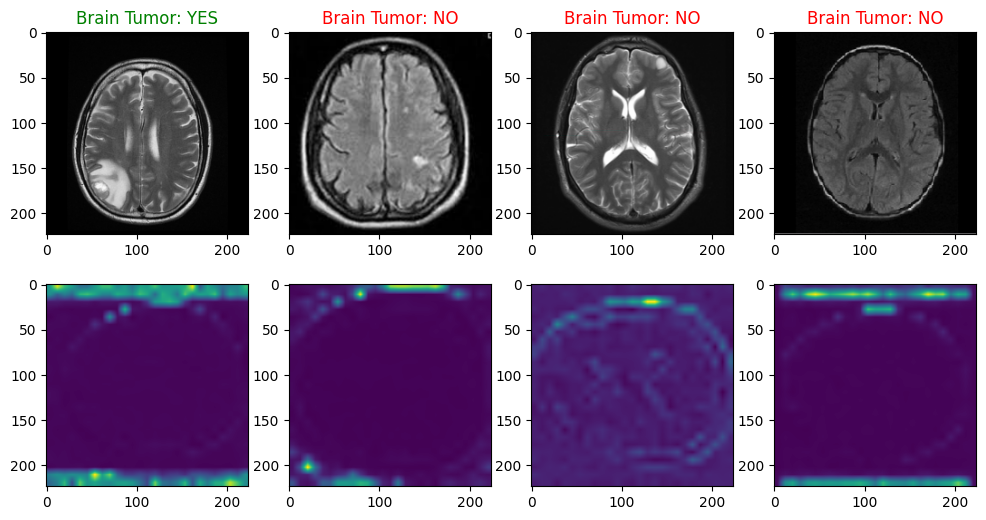

In [451]:
idxs = np.random.choice(len(imgs), size = 4)
fig, ax = plt.subplots(2 , 4, figsize = (12, 6))

for n, i in enumerate(idxs):
    img = resize()(image=imgs[i])['image']
    ax[0, n].imshow(img)
    color = 'green' if labels[i] == 1 else 'red'
    ax[0, n].set_title(f"Brain Tumor: {'YES'if labels[i] == 1 else 'NO'}", color = color)
    att = get_attention_map(img = imgs[i], layer=0)
    ax[1, n].imshow(att)

fig, ax = plt.subplots(2 , 4, figsize = (12, 6))
for n, i in enumerate(idxs):
    img = resize()(image=imgs[i])['image']
    ax[0, n].imshow(img)
    color = 'green' if labels[i] == 1 else 'red'
    ax[0, n].set_title(f"Brain Tumor: {'YES'if labels[i] == 1 else 'NO'}", color = color)
    att = get_attention_map(img = imgs[i], layer=1)
    ax[1, n].imshow(att)

fig, ax = plt.subplots(2 , 4, figsize = (12, 6))
for n, i in enumerate(idxs):
    img = resize()(image=imgs[i])['image']
    ax[0, n].imshow(img)
    color = 'green' if labels[i] == 1 else 'red'
    ax[0, n].set_title(f"Brain Tumor: {'YES'if labels[i] == 1 else 'NO'}", color = color)
    att = get_attention_map(img = imgs[i], layer=2)
    ax[1, n].imshow(att)
    

## Tokenization & Positional Encoding

In [35]:
class CreatePatches2(nn.Module):
    def __init__(
        self, channels=3, embed_dim=768, patch_size=16
    ):
        super().__init__()
        self.patch = nn.Conv2d(
            in_channels=channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=int(patch_size/2)
        )
    def forward(self, x):
        # Flatten along dim = 2 to maintain channel dimension.
        patches = self.patch(x).flatten(2).transpose(1, 2)
        return patches


class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.pre_norm = nn.LayerNorm(embed_dim, eps=1e-06)
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm = nn.LayerNorm(embed_dim, eps=1e-06)
        self.MLP = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        x_norm = self.pre_norm(x)
        # MultiheadAttention returns attention output and weights,
        # we need only the outputs, so [0] index.
        attention_out, attention_weights = self.attention(x_norm, x_norm, x_norm, need_weights = True)
        x = x + attention_out
        x = x + self.MLP(self.norm(x))
        return x, attention_weights
    
class ViT2(nn.Module):
    def __init__(
        self, 
        config
    ):
        """img_size=224,
        in_channels=3,
        patch_size=16,
        embed_dim=768,
        hidden_dim=3072,
        num_heads=12,
        num_layers=12,
        dropout=0.0,
        num_classes=1000"""
        img_size = config['img_size']
        in_channels = config['in_channels']
        patch_size = config['patch_size']
        embed_dim = config['embed_dim']
        hidden_dim = config['hidden_dim']
        num_heads = config['num_heads']
        num_layers = config['num_layers']
        dropout = config['dropout']
        num_classes = config['num_classes']

        patches = CreatePatches2

        super().__init__()
        self.patch_size = patch_size
        num_patches = 27*27
        self.patches = patches(
            channels=in_channels,
            embed_dim=embed_dim,
            patch_size=patch_size
        )
        # Postional encoding.
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.attn_layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.attn_layers.append(
                AttentionBlock(embed_dim, hidden_dim, num_heads, dropout)
            )
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(embed_dim, eps=1e-06)
        self.head = nn.Sequential(nn.Linear(embed_dim, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid())
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x, return_weights = False):
        x = self.patches(x)
        b, n, _ = x.shape
 
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)
        att_list = []
        for layer in self.attn_layers:
            x, att = layer(x)
            att_list.append(att)
        x = self.ln(x)
        x = x[:, 0]
        
        if (return_weights):
            return self.head(x), att_list
        return self.head(x)

In [36]:
vit_config = generate_vit_config(complexity=2)[0]
print(vit_config)
good_vit = ViT2(config=vit_config)
performance = train_model(use_model=good_vit, n_epochs=30, lr=1e-4)

{'img_size': 224, 'in_channels': 3, 'patch_size': 16, 'embed_dim': 144, 'hidden_dim': 432, 'num_heads': 6, 'num_layers': 3, 'dropout': 0.0, 'num_classes': 1}
Metric is Accucracy
Epoch : # 1
------------------------------
Training -- Loss: 0.6646, Metric: 38.07%
Validation -- Loss: 0.6375, Metric: 32.64%
Epoch : # 2
------------------------------
Training -- Loss: 0.6644, Metric: 38.07%
Validation -- Loss: 0.6374, Metric: 32.64%
Epoch : # 3
------------------------------
Training -- Loss: 0.6672, Metric: 53.57%
Validation -- Loss: 0.6545, Metric: 54.17%
Epoch : # 4
------------------------------
Training -- Loss: 0.6699, Metric: 60.46%
Validation -- Loss: 0.6718, Metric: 54.17%
Epoch : # 5
------------------------------
Training -- Loss: 0.6697, Metric: 54.72%
Validation -- Loss: 0.6718, Metric: 48.61%
Epoch : # 6
------------------------------
Training -- Loss: 0.6781, Metric: 56.63%
Validation -- Loss: 0.6542, Metric: 52.78%
Epoch : # 7
------------------------------
Training -- Loss:

In [37]:
good_vit.eval()


def get_attention_map(img, layer=2):
    img = resize()(image=img)['image'][:,:,:,None]
    img = torch.permute(torch.tensor(img, dtype=torch.float32), (3, 2, 1, 0))
    pred, att = good_vit(img, return_weights = True)
    last = att[layer]
    cls = torch.mean(last[:, 1:, 1:], dim=1)
    num_patches = cls.size(-1)
    size = int(np.sqrt(num_patches))
    cls = cls.view(-1, size, size)
    attention_maps = cls.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(224, 224), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze(1)
    return attention_maps.squeeze().detach().numpy()

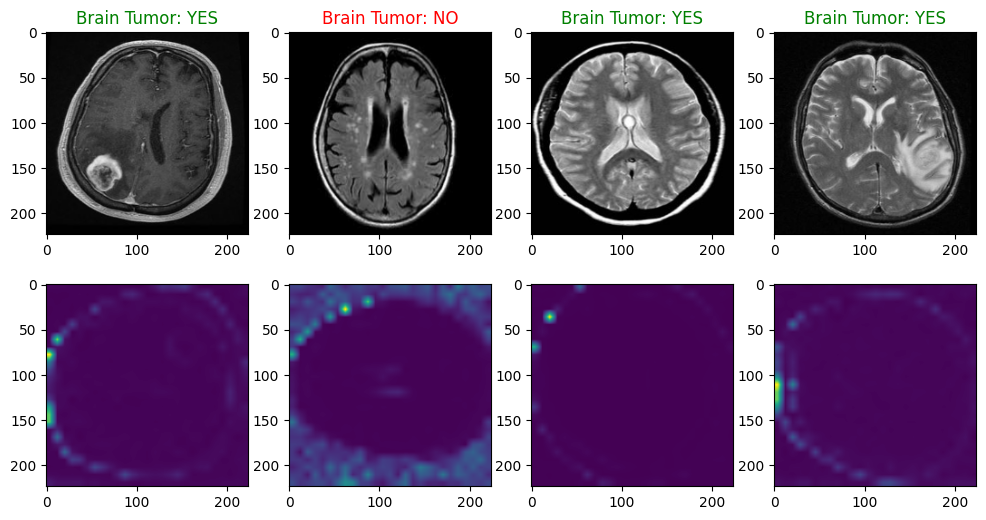

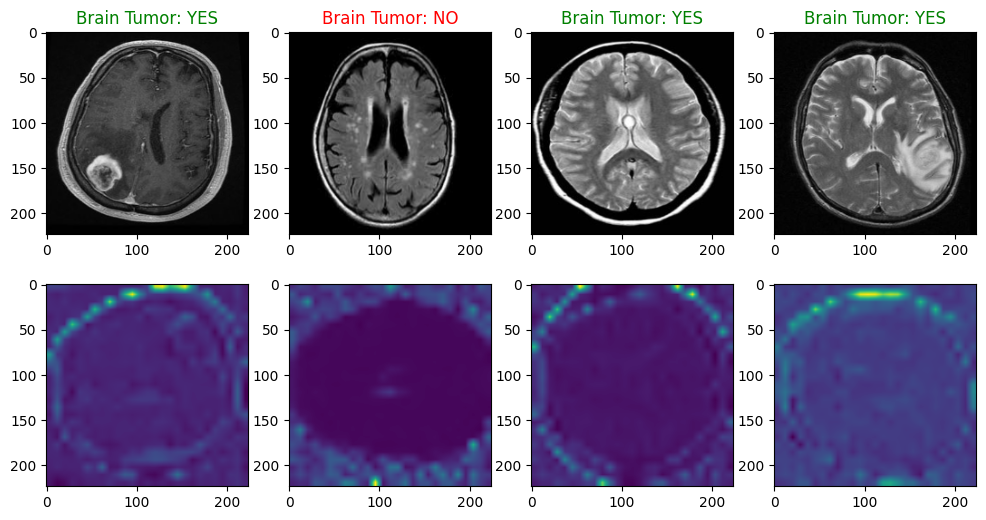

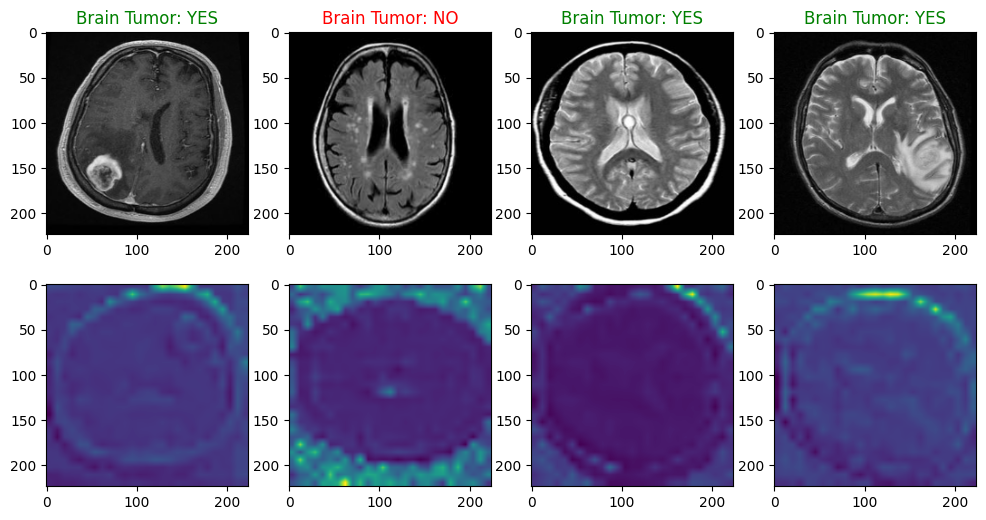

In [41]:
idxs = np.random.choice(len(imgs), size = 4)
fig, ax = plt.subplots(2 , 4, figsize = (12, 6))

for n, i in enumerate(idxs):
    img = resize()(image=imgs[i])['image']
    ax[0, n].imshow(img)
    color = 'green' if labels[i] == 1 else 'red'
    ax[0, n].set_title(f"Brain Tumor: {'YES'if labels[i] == 1 else 'NO'}", color = color)
    att = get_attention_map(img = imgs[i], layer=0)
    ax[1, n].imshow(att)

fig, ax = plt.subplots(2 , 4, figsize = (12, 6))
for n, i in enumerate(idxs):
    img = resize()(image=imgs[i])['image']
    ax[0, n].imshow(img)
    color = 'green' if labels[i] == 1 else 'red'
    ax[0, n].set_title(f"Brain Tumor: {'YES'if labels[i] == 1 else 'NO'}", color = color)
    att = get_attention_map(img = imgs[i], layer=1)
    ax[1, n].imshow(att)

fig, ax = plt.subplots(2 , 4, figsize = (12, 6))
for n, i in enumerate(idxs):
    img = resize()(image=imgs[i])['image']
    ax[0, n].imshow(img)
    color = 'green' if labels[i] == 1 else 'red'
    ax[0, n].set_title(f"Brain Tumor: {'YES'if labels[i] == 1 else 'NO'}", color = color)
    att = get_attention_map(img = imgs[i], layer=2)
    ax[1, n].imshow(att)